In [1]:
!wget http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip

--2023-05-12 19:07:33--  http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip [following]
--2023-05-12 19:07:33--  https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81363704 (78M) [application/zip]
Saving to: ‘trainingandtestdata.zip’

trainingandtestdata 100%[===================>]  77.59M  47.6MB/s    in 1.6s    

2023-05-12 19:07:35 (47.6 MB/s) - ‘trainingandtestdata.zip’ saved [81363704/81363704]



In [2]:
!unzip /content/trainingandtestdata.zip

Archive:  /content/trainingandtestdata.zip
  inflating: testdata.manual.2009.06.14.csv  
  inflating: training.1600000.processed.noemoticon.csv  


[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

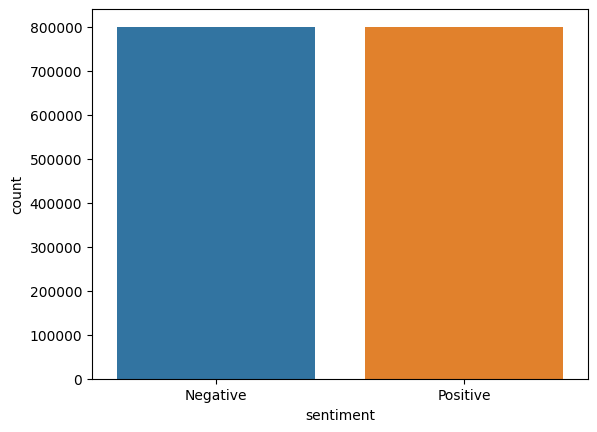

In [3]:
import pandas as pd
import seaborn as sns
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
df=pd.read_csv("/content/training.1600000.processed.noemoticon.csv" , encoding='latin-1', header=None, names=DATASET_COLUMNS)
df = df[['sentiment','text']]
# Replacing the values to ease understanding.
df['sentiment'] = df['sentiment'].replace(4,1)
ax= sns.countplot(x=df['sentiment'])
ax.set_xticklabels(['Negative','Positive'], rotation=0)

In [4]:
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
stop_words = stopwords.words("english")
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}
nltk.download('wordnet')


def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            if word not in stop_words:
              if len(word)>1:
                  # Lemmatizing the word.
                  word = wordLemm.lemmatize(word)
                  tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [5]:
processedtext = preprocess(df["text"])

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
x_train_text, x_test_text, y_train, y_test = train_test_split(processedtext, df['sentiment'], test_size=0.2, random_state=42,stratify=df['sentiment'])

In [8]:
from nltk.tokenize import WhitespaceTokenizer
tk = WhitespaceTokenizer()

print('Before Tokenize: ', x_train_text[1])
print('After Tokenize: ', tk.tokenize(x_train_text[1]))

Before Tokenize:  worst headache ever 
After Tokenize:  ['worst', 'headache', 'ever']


In [9]:
from tqdm.notebook import tqdm
x_train_token = [tk.tokenize(s) for s in tqdm(x_train_text)]
x_test_token = [tk.tokenize(s) for s in tqdm(x_test_text)]

  0%|          | 0/1280000 [00:00<?, ?it/s]

  0%|          | 0/320000 [00:00<?, ?it/s]

In [10]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
from collections import Counter

words = Counter()
for s in x_train_token:
  for w in s:
    words[w] += 1

sorted_words = list(words.keys())
sorted_words.sort(key=lambda w: words[w], reverse=True)
print(f"Number of different Tokens in our Dataset: {len(sorted_words)}")
print(sorted_words[:100])

Number of different Tokens in our Dataset: 217812
['USER', 'day', 'good', 'get', 'like', 'go', 'URL', 'quot', 'today', 'work', 'love', 'time', 'going', 'got', 'lol', 'one', 'back', 'know', 'im', 'really', 'want', 'amp', 'see', 'night', 'think', 'still', 'well', 'new', 'need', 'home', 'thanks', 'oh', 'miss', 'much', 'last', 'feel', 'morning', 'make', 'hope', 'tomorrow', 'twitter', 'great', 'haha', 'wish', 'sad', 'sleep', 'fun', 'come', 'week', 'right', 'bad', 'would', 'happy', 'sorry', 'thing', 'tonight', 'friend', 'way', 'getting', 'though', 'look', 'gonna', 'better', 'nice', 'watching', 'say', 'yeah', 'bed', 'wait', 'could', 'hate', 'school', 'people', 'hour', 'yes', 'guy', 'weekend', 'even', 'hey', 'soo', 'show', 'next', 'take', 'lt', 'dont', 'tweet', 'awesome', 'soon', 'thank', 'never', 'cant', 'let', 'life', 'long', 'little', 'working', 'first', 'year', 'wanna', 'aww']


In [12]:
count_occurences = sum(words.values())

accumulated = 0
counter = 0

while accumulated < count_occurences * 0.8:
  accumulated += words[sorted_words[counter]]
  counter += 1

print(f"The {counter * 100 / len(words)}% most common words "
      f"account for the {accumulated * 100 / count_occurences}% of the occurrences")

The 0.9912217875966429% most common words account for the 80.00119163352436% of the occurrences


In [13]:
num_words_dict = 10000
# We reserve two numbers for special tokens.
most_used_words = sorted_words[:num_words_dict-2]

In [14]:
# dictionary to go from words to idx
word_to_idx = {}
# dictionary to go from idx to words (just in case)
idx_to_word = {}


# We include the special tokens first
PAD_token = 0
UNK_token = 1

word_to_idx['PAD'] = PAD_token
word_to_idx['UNK'] = UNK_token

idx_to_word[PAD_token] = 'PAD'
idx_to_word[UNK_token] = 'UNK'

# We popullate our dictionaries with the most used words
for num,word in enumerate(most_used_words):
  word_to_idx[word] = num + 2
  idx_to_word[num+2] = word

In [15]:
# A function to convert list of tokens to list of indexes
def tokens_to_idx(sentences_tokens,word_to_idx):
  sentences_idx = []
  for sent in sentences_tokens:
    sent_idx = []
    for word in sent:
      if word in word_to_idx:
        sent_idx.append(word_to_idx[word])
      else:
        sent_idx.append(word_to_idx['UNK'])
    sentences_idx.append(sent_idx)
  return sentences_idx

In [16]:
x_train_idx = tokens_to_idx(x_train_token,word_to_idx)
x_test_idx = tokens_to_idx(x_test_token,word_to_idx)
     

some_number = 1
print('Before converting: ', x_train_token[some_number])
print('After converting: ', x_train_idx[some_number])

Before converting:  ['worst', 'headache', 'ever']
After converting:  [572, 316, 138]


In [17]:
import numpy as np
tweet_lens = np.asarray([len(sentence) for sentence in x_train_idx])
print('Max tweet word length: ',tweet_lens.max())
print('Mean tweet word length: ',np.median(tweet_lens))
print('99% percent under: ',np.quantile(tweet_lens,0.99))

Max tweet word length:  34
Mean tweet word length:  7.0
99% percent under:  17.0


In [18]:
def tokens_to_idx(sentences_tokens,word_to_idx):
  sentences_idx = []
  for sent in sentences_tokens:
    sent_idx = []
    for word in sent:
      if word in word_to_idx:
        sent_idx.append(word_to_idx[word])
      else:
        sent_idx.append(word_to_idx['UNK'])
    sentences_idx.append(sent_idx)
  return sentences_idx


In [19]:
 import numpy as np
 # We choose the max length
 max_length = 40

# A function to make all the sequence have the same lenght
# Note that the output is a Numpy matrix
 def padding(sentences, seq_len):
  features = np.zeros((len(sentences), seq_len),dtype=int)
  for ii, tweet in enumerate(sentences):
    len_tweet = len(tweet)
    if len_tweet != 0:
      if len_tweet <= seq_len:
        # If its shorter, we fill with zeros (the padding Token index)
        features[ii, -len(tweet):] = np.array(tweet)[:seq_len]
      if len_tweet > seq_len:
        # If its larger, we take the last 'seq_len' indexes
        features[ii, :] = np.array(tweet)[-seq_len:]
  return features
     

# We convert our list of tokens into a numpy matrix
# where all instances have the same lenght
x_train_pad = padding(x_train_idx,max_length)
x_test_pad = padding(x_test_idx,max_length)

# We convert our target list a numpy matrix
y_train_np = np.asarray(y_train)
y_test_np = np.asarray(y_test)
     

some_number = 2
print('Before padding: ', x_train_idx[some_number])
print('After padding: ', x_train_pad[some_number])

Before padding:  [2, 46, 399, 24, 34, 116, 68, 529, 49, 18, 2964]
After padding:  [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    2   46  399   24   34  116   68  529   49   18 2964]


In [38]:
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train_np))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test_np))

# Batch size (this is an important hyperparameter)
batch_size = 100

# dataloaders
# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size,drop_last = True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size,drop_last = True)
test_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size,drop_last = True)

In [36]:
class TweetRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TweetRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.embedding(x)
        # Forward propagate the RNN
        out, _ = self.rnn(x)
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out



In [33]:
def train_rnn_network(model, train, valid, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    for epoch in range(num_epochs):
        for tweets, labels in train:
            optimizer.zero_grad()
            pred = model(tweets)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_loader))
        valid_acc.append(get_accuracy(model, valid_loader))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, train_acc[-1], valid_acc[-1]))
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

In [34]:
def get_accuracy(model, data_loader):
    correct, total = 0, 0
    for tweets, labels in data_loader:
        output = model(tweets)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total


Epoch 1; Loss 0.487513; Train Acc 0.754235; Val Acc 0.752184
Epoch 2; Loss 0.398277; Train Acc 0.774486; Val Acc 0.771216
Epoch 3; Loss 0.414088; Train Acc 0.780998; Val Acc 0.777153
Epoch 4; Loss 0.419112; Train Acc 0.783893; Val Acc 0.779694
Epoch 5; Loss 0.388916; Train Acc 0.787149; Val Acc 0.782844


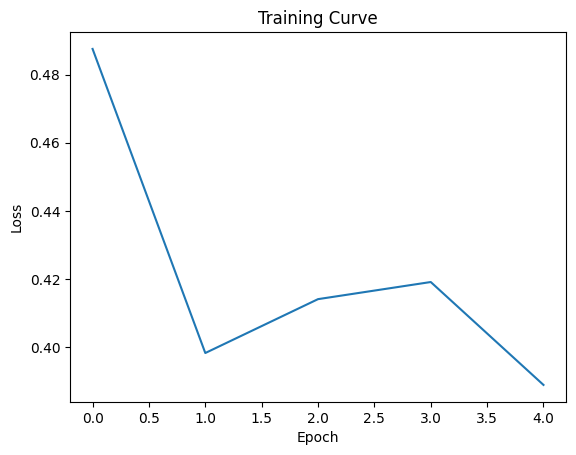

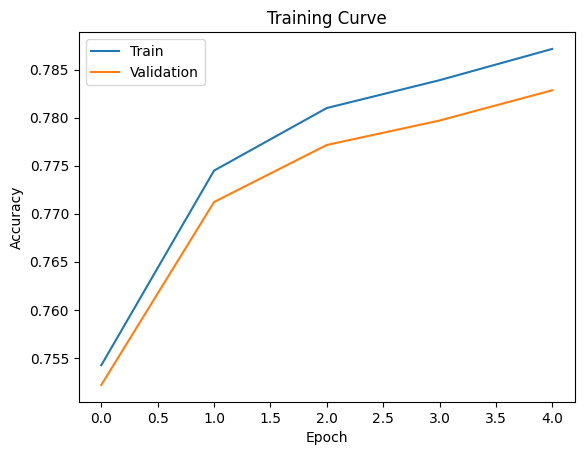

0.78284375

In [40]:
model = TweetRNN(32, 50, 2)
train_rnn_network(model, train_loader, valid_loader, num_epochs=5, learning_rate=2e-4)
get_accuracy(model, test_loader)

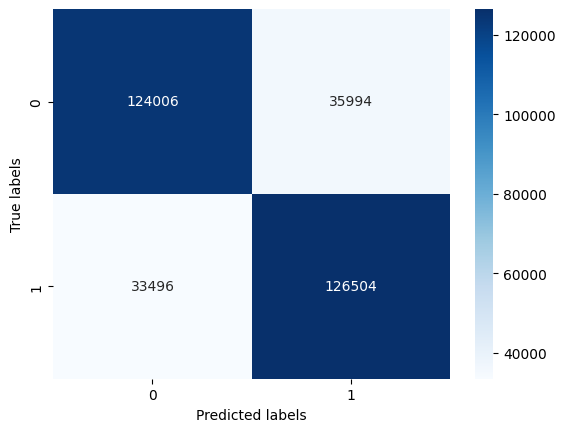

In [41]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for x, y in test_loader:
        output = model(x)
        _, preds = torch.max(output, 1)
        y_true.extend(y.tolist())
        y_pred.extend(preds.tolist())

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

# lstm


In [ ]:
class TweetLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TweetLSTM, self).__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb(x)
        # Set an initial hidden state and cell state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        c0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the LSTM
        out, _ = self.rnn(x, (h0, c0))
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
model_lstm = TweetLSTM(32, 50, 2)
train_rnn_network(model_lstm, train_loader, valid_loader, num_epochs=5, learning_rate=2e-4)
get_accuracy(model_lstm, test_loader)

Epoch 1; Loss 0.520715; Train Acc 0.760971; Val Acc 0.758425
Epoch 2; Loss 0.593789; Train Acc 0.776853; Val Acc 0.773012


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
model_lstm.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for x, y in test_loader:
        output = model_lstm(x)
        _, preds = torch.max(output, 1)
        y_true.extend(y.tolist())
        y_pred.extend(preds.tolist())

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

# GRU

In [42]:
class TweetGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TweetGRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.hidden_size = hidden_size
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.embedding(x)
        # Forward propagate the RNN
        out, _ = self.rnn(x)
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
model_GRU = TweetGRU(32, 50, 2)
train_rnn_network(model_GRU, train_loader, valid_loader, num_epochs=5, learning_rate=2e-4)
get_accuracy(model_GRU, test_loader)

Epoch 1; Loss 0.520715; Train Acc 0.760971; Val Acc 0.758425
Epoch 2; Loss 0.593789; Train Acc 0.776853; Val Acc 0.773012
Epoch 3; Loss 0.501671; Train Acc 0.784113; Val Acc 0.778897
Epoch 4; Loss 0.483922; Train Acc 0.787200; Val Acc 0.781119


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
model_GRU.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for x, y in test_loader:
        output = model_GRU(x)
        _, preds = torch.max(output, 1)
        y_true.extend(y.tolist())
        y_pred.extend(preds.tolist())

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()